## EERIE ocean plotting

For the ocean you need a newer version of eccodes, and in general newer environment.

Easy way:

```shell

cd ~/.
mkdir -p .local/share/jupyter/kernels/iccp
cp /home/a/a270088/.local/share/jupyter/kernels/iccp/* .local/share/jupyter/kernels/iccp

```

Hard way:
You have to have mamba installed, for example following instructions on DKRZ: https://docs.dkrz.de/doc/levante/code-development/python.html#set-up-conda-for-individual-environments

```shell
mamba create -n iccp python=3.11
conda activate iccp

mamba install xarray dask cartopy matplotlib intake intake-xarray netcdf4 ipykernel scipy aiohttp intake-esm fastparquet

pip install eccodes
pip install gribscan

python -m ipykernel install --user --name iccp --display-name="iccp"

```

In [1]:
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
from matplotlib import cm

In [2]:
import xarray as xr
import numpy as np
import intake

eerie_cat=intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

model = 'ifs-fesom2-sr'
expid = 'hist-1950'  # 'highres-future-ssp245', 'hist-1950', 'eerie-control-1950', 'eerie-spinup-1950'
version = 'v20240304'    #
realm='ocean'  # 'ocean' , 'land', 'atmos'
gridspec = 'native' # 'native', 'gr025'

cat_data=eerie_cat['dkrz.disk.model-output'][model][expid][version][realm][gridspec]
print(list(cat_data))

# ds = cat_data['2D_daily_avg'].to_dask()
# ds

['2D_daily_avg', '3D_daily_avg', '3D_monthly_avg_elems']


In [3]:
ds = cat_data['2D_daily_avg'].to_dask()
ds

/work/ab0995/a270088/mambaforge/envs/iccp/lib/python3.11/site-packages/zarr/core/metadata/v2.py:190: ZarrUserWarning: Found an empty list of filters in the array metadata document. This is contrary to the Zarr V2 specification, and will cause an error in the future. Use None (or Null in a JSON document) instead of an empty list of filters.
  warnings.warn(msg, ZarrUserWarning, stacklevel=1)


<xarray.Dataset> Size: 4TB
Dimensions:        (time: 7305, value: 7402886, node_index: 7402886)
Coordinates:
  * time           (time) datetime64[ns] 58kB 1950-01-01T12:00:00 ... 1969-12...
  * node_index     (node_index) int64 59MB 0 1 2 3 ... 7402883 7402884 7402885
Dimensions without coordinates: value
Data variables:
    avg_mlotst125  (time, value) float64 433GB dask.array<chunksize=(2, 7402886), meta=np.ndarray>
    avg_siconc     (time, value) float64 433GB dask.array<chunksize=(2, 7402886), meta=np.ndarray>
    avg_sisnthick  (time, value) float64 433GB dask.array<chunksize=(2, 7402886), meta=np.ndarray>
    avg_sithick    (time, value) float64 433GB dask.array<chunksize=(2, 7402886), meta=np.ndarray>
    avg_siue       (time, value) float64 433GB dask.array<chunksize=(2, 7402886), meta=np.ndarray>
    avg_sivn       (time, value) float64 433GB dask.array<chunksize=(2, 7402886), meta=np.ndarray>
    avg_sos        (time, value) float64 433GB dask.array<chunksize=(2, 7402886), meta=np.ndarray>
    avg_tos        (time, value) float64 433GB dask.array<chunksize=(2, 7402886), meta=np.ndarray>
    avg_zos        (time, value) float64 433GB dask.array<chunksize=(2, 7402886), meta=np.ndarray>
Attributes: (12/37)
    edition:               2
    centre:                ecmf
    centreDescription:     European Centre for Medium-Range Weather Forecasts
    subCentre:             1003
    uuidOfHGrid:           7a33ecae-be22-e7d5-ca4a-bbd819a43240
    history:               🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan...
    ...                    ...
    parent_activity_id:    HighResMIP
    sub_experiment_id:     none
    experiment:            coupled historical 1950-2014
    source:                IFS-FESOM2-SR (2023): \naerosol: none, prescribed ...
    institution:           Alfred Wegener Institute, Helmholtz Centre for Pol...
    sub_experiment:        none

In [4]:
grid = xr.open_dataset('/work/ab0995/a270088/meshes/NG5/fesom.mesh.diag.nc')

sh: getfattr: command not found


In [5]:
lon = grid.lon.values
lat = grid.lat.values

In [6]:
import matplotlib.pylab as plt

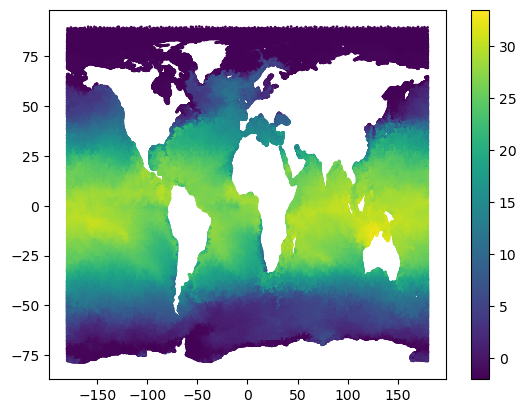

In [7]:
sstep = 10
plt.scatter(lon[::sstep], lat[::sstep], s=1, c=ds['avg_tos'][0,::sstep])
plt.colorbar()

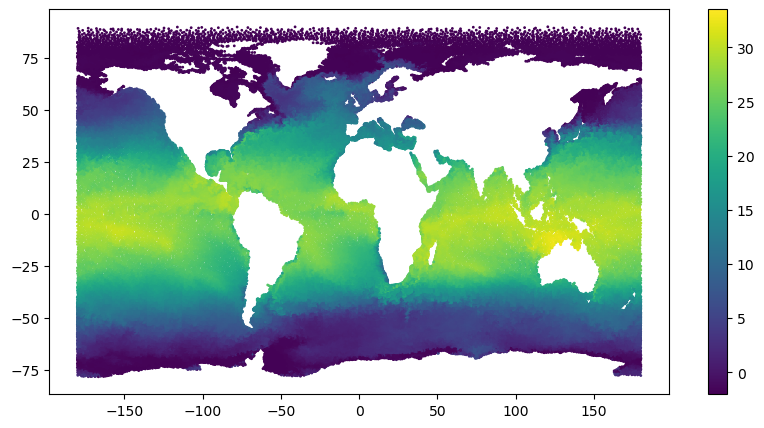

In [14]:
sstep = 50
plt.figure(figsize=(10,5))
plt.scatter(lon[::sstep], lat[::sstep], s=1, c=ds['avg_tos'][0,::sstep])
plt.colorbar()

In [15]:
left = 120
right = 140
bottom = 30
top = 45

In [16]:
region = (lon < right) & (lon>left) & (lat > bottom) & (lat < top)

In [17]:
data_sample = ds['avg_tos'][0,:].values

In [18]:
data_sample[region]

array([20.00870562, 20.11470842, 20.05283403, ..., 19.97292757,
       19.98417711, 20.08146334], shape=(76904,))

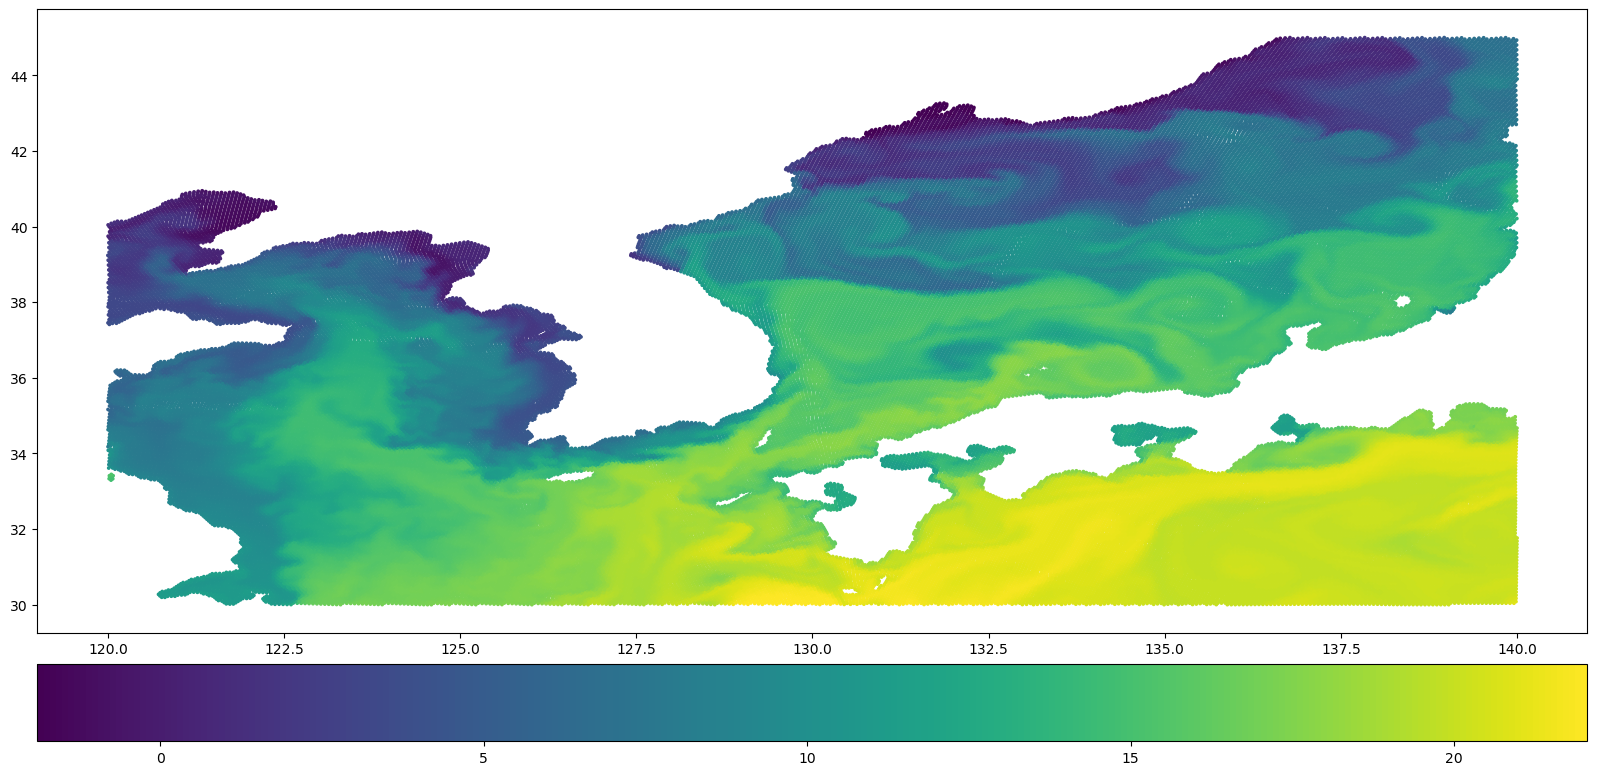

In [19]:
plt.figure(figsize=(20,10))
plt.scatter(lon[region], lat[region], s=3 , c=data_sample[region])
plt.colorbar(orientation='horizontal', pad=0.04)

In [20]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm

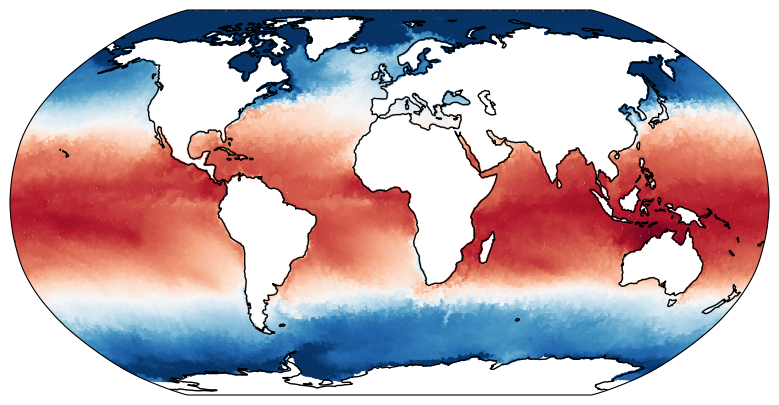

In [21]:
sstep = 30
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution='110m', color='k')
ax.scatter(lon[::sstep], lat[::sstep], s=1 , c=data_sample[::sstep],
            cmap=cm.RdBu_r, transform=ccrs.PlateCarree())

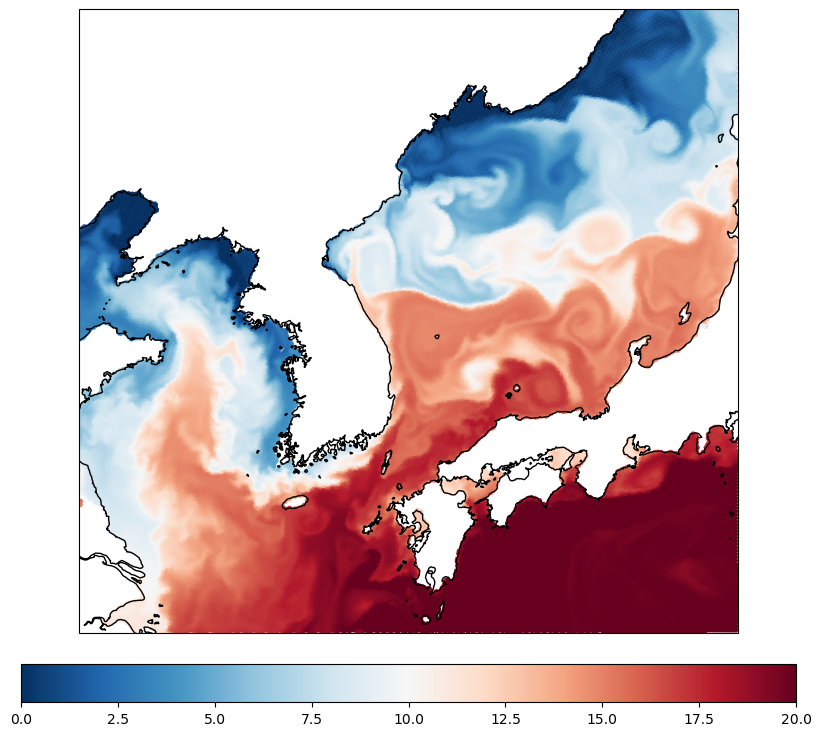

In [22]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='10m', color='k')
ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
mm = ax.scatter(lon[region], lat[region], s=1 , c=data_sample[region], 
           vmin=0, vmax=20,
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())
plt.colorbar(mm, orientation='horizontal', pad=0.04)

## Simple interpolation to a regular grid

In [23]:
lon_geo = np.linspace(120, 140, 160)
lat_geo = np.linspace(30, 45, 160)
lon_geo2, lat_geo2 = np.meshgrid(lon_geo, lat_geo)

In [24]:
points = np.vstack((lon, lat)).T

In [25]:
%%time
nn_interpolation = NearestNDInterpolator(points, data_sample)

CPU times: user 2.91 s, sys: 84.7 ms, total: 3 s
Wall time: 3.06 s


In [26]:
interpolated_nn = nn_interpolation((lon_geo2, lat_geo2))

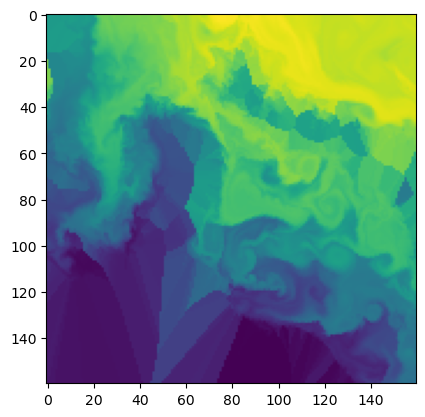

In [27]:
plt.imshow(interpolated_nn)

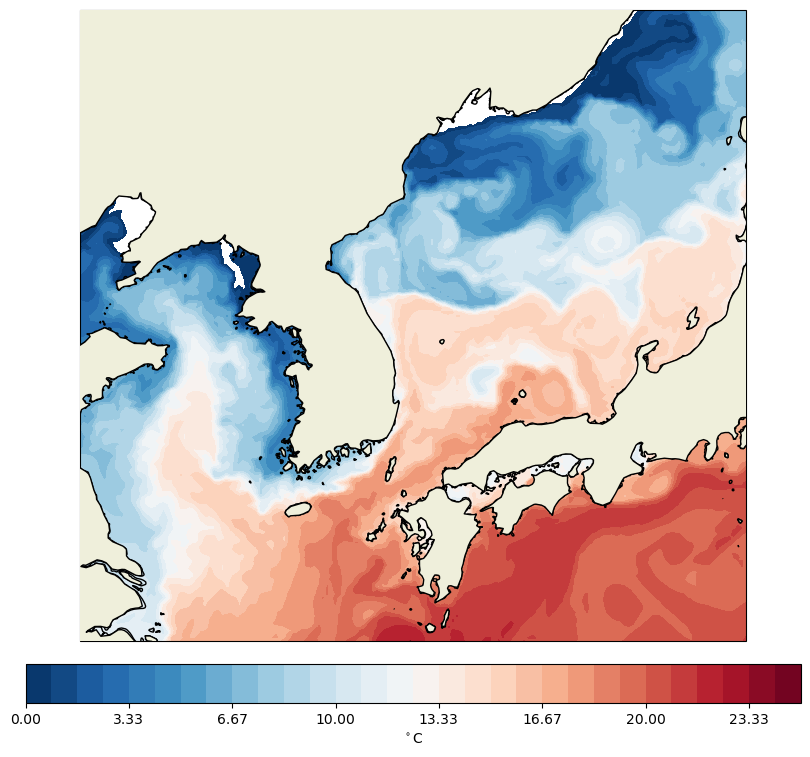

In [28]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='10m', color='k')
# ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
#ax.stock_img()
img = ax.contourf(lon_geo, lat_geo, interpolated_nn, 
           levels = np.linspace(0,25,31),
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())
# ax.contour(lon_geo, lat_geo, interpolated_nn-273, 
#            levels = np.linspace(-30,30,31),
#            transform=ccrs.PlateCarree(), colors='k', linewidths=0.5)
#ax.add_feature(
#            cfeature.GSHHSFeature(levels=[1], scale="low", facecolor="lightgray")
#        )
#ax.stock_img()
ax.add_feature(cfeature.LAND, zorder=10, edgecolor='black')
cbar = plt.colorbar(img, orientation='horizontal', pad=0.03)
cbar.set_label('$^\circ$C')

## Interpolate to grid from observations

In [29]:
obs_file = xr.open_dataset('/home/a/a270088/PYTHON/EERIE_hackathon_2023/COMMON/sst.mon.mean.nc')

sh: getfattr: command not found


In [30]:
lon_sst = obs_file.lon.data
lat_sst = obs_file.lat.data

lon_360 = np.where(lon_sst>180, lon_sst-360, lon_sst)
lon_sst2, lat_sst2 = np.meshgrid(lon_360, lat_sst)

In [31]:
data_on_obs_grid = NearestNDInterpolator(points, data_sample)(lon_sst2, lat_sst2)

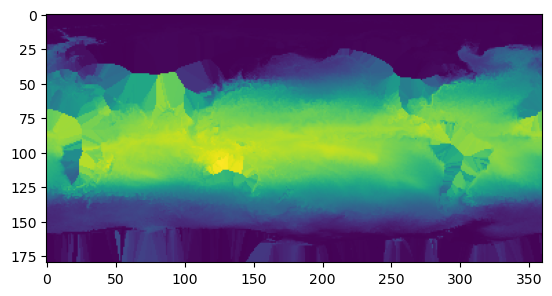

In [32]:
plt.imshow(data_on_obs_grid)

In [33]:
obs_sample = obs_file.sst.sel(time='2020-01').data[0,:,:]

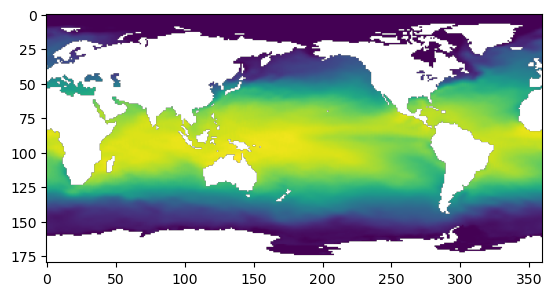

In [34]:
plt.imshow(obs_sample)

In [35]:
model_sst_sample = ds['avg_tos'][0,:].values

In [36]:
model_sst_sample_on_obs_grid = NearestNDInterpolator(points, model_sst_sample)(lon_sst2, lat_sst2)

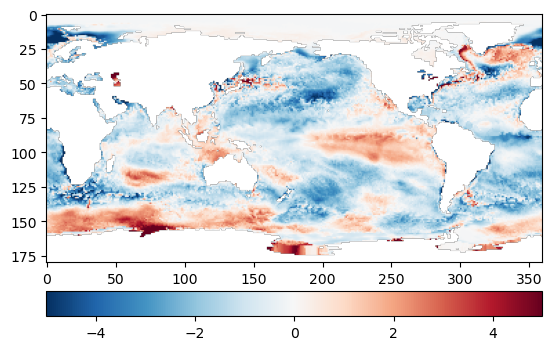

In [37]:
difference = model_sst_sample_on_obs_grid-obs_sample
plt.imshow(difference, vmin=-5, vmax=5, cmap=cm.RdBu_r)
plt.colorbar(orientation='horizontal', pad=0.08, )

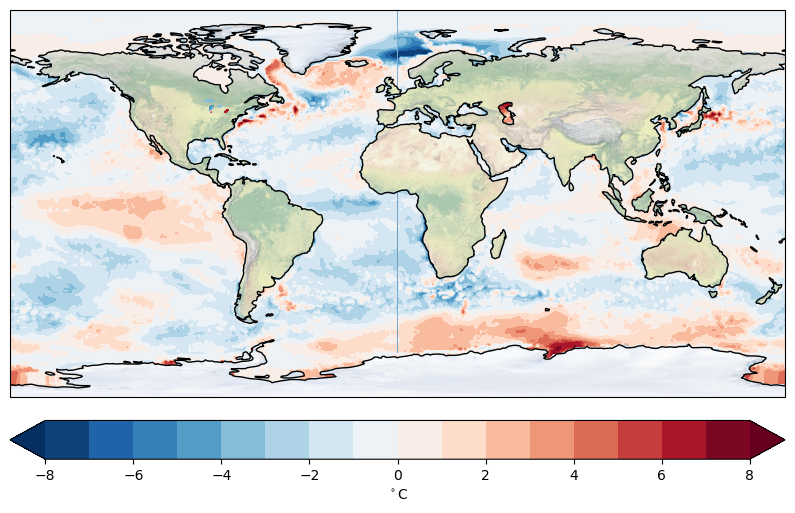

In [38]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='110m', color='k')
img = ax.contourf(lon_sst, lat_sst, difference, 
           levels = np.linspace(-8,8,17),
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree(), extend='both')
ax.stock_img()
cbar = plt.colorbar(img, orientation='horizontal', pad=0.03)
cbar.set_label('$^\circ$C')

## Advanced interpolation

In [39]:
lon_geo = np.linspace(120, 140, 160)
lat_geo = np.linspace(30, 45, 160)
lon_geo2, lat_geo2 = np.meshgrid(lon_geo, lat_geo)

In [40]:
%%time
nn_interpolation_fesom = NearestNDInterpolator(points, data_sample)
fesom_data = nn_interpolation_fesom((lon_geo2, lat_geo2))

CPU times: user 2.96 s, sys: 76.8 ms, total: 3.04 s
Wall time: 3.04 s


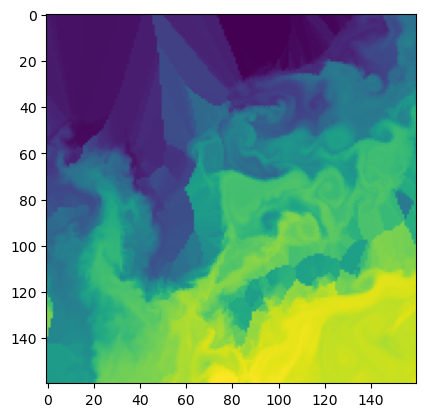

In [41]:
plt.imshow(plt.flipud(fesom_data))


In [42]:
grid

<xarray.Dataset> Size: 7GB
Dimensions:            (elem: 14741520, nod2: 7402886, nz: 70, n3: 3, n2: 2,
                        N: 8, edg_n: 22144811, n4: 4, nz1: 69)
Coordinates:
  * nz                 (nz) float64 560B 0.0 -5.0 -10.0 ... -6e+03 -6.35e+03
  * nz1                (nz1) float64 552B -2.5 -7.5 ... -5.825e+03 -6.175e+03
Dimensions without coordinates: elem, nod2, n3, n2, N, edg_n, n4
Data variables: (12/19)
    elem_area          (elem) float64 118MB ...
    nlevels_nod2D      (nod2) int32 30MB ...
    nlevels            (elem) int32 59MB ...
    nod_in_elem2D_num  (nod2) int32 30MB ...
    nod_part           (nod2) int32 30MB ...
    elem_part          (elem) int32 59MB ...
    ...                 ...
    nod_in_elem2D      (N, nod2) int32 237MB ...
    edges              (n2, edg_n) int32 177MB ...
    edge_tri           (n2, edg_n) int32 177MB ...
    edge_cross_dxdy    (n4, edg_n) float64 709MB ...
    gradient_sca_x     (elem, n3) float64 354MB ...
    gradient_sca_y     (elem, n3) float64 354MB ...

In [43]:
elements = grid.elements.data.astype('int32') - 1


In [44]:
elements.T

array([[      0,       1,    1168],
       [      0,    1168,    1169],
       [      1,       3,       2],
       ...,
       [7402878, 7402880, 7402879],
       [7402882, 7402883, 7402884],
       [7402883, 7402885, 7402884]], shape=(14741520, 3), dtype=int32)

In [45]:
d = lon[elements.T].max(axis=1) - lon[elements.T].min(axis=1)
no_cyclic_elem = np.argwhere(d < 100).ravel()

In [46]:
import matplotlib.tri as mtri

In [47]:
triang = mtri.Triangulation(lon, lat, elements.T[no_cyclic_elem])


In [48]:
%%time
masked_data = mtri.LinearTriInterpolator(triang, data_sample)(lon_geo2, lat_geo2)

CPU times: user 3min 10s, sys: 4.59 s, total: 3min 15s
Wall time: 3min 20s


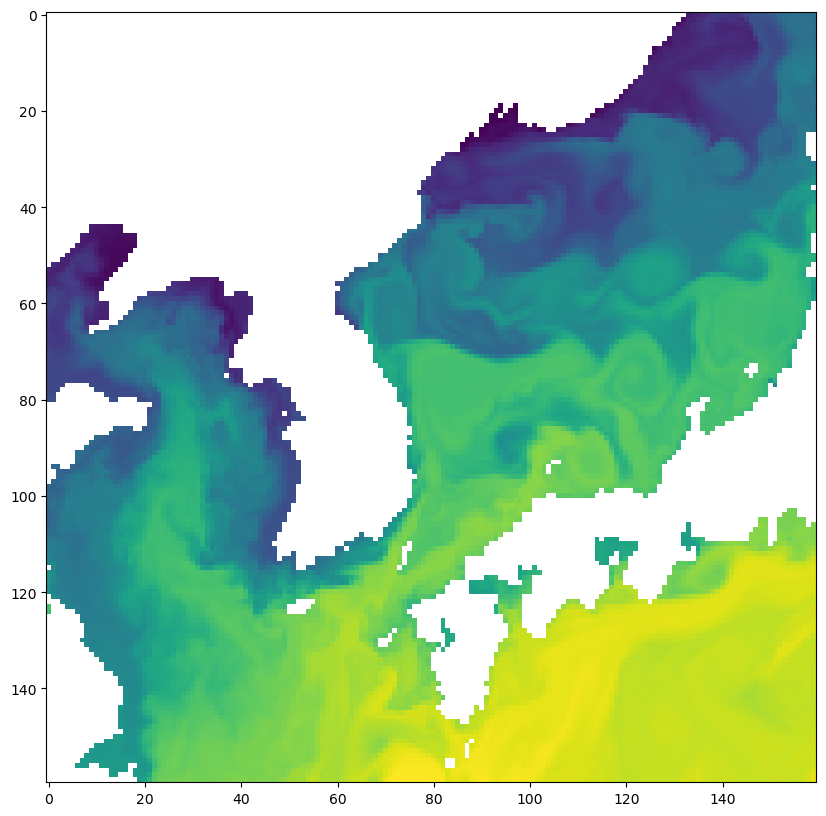

In [49]:
plt.figure(figsize=(10,10))
plt.imshow(np.flipud(masked_data))

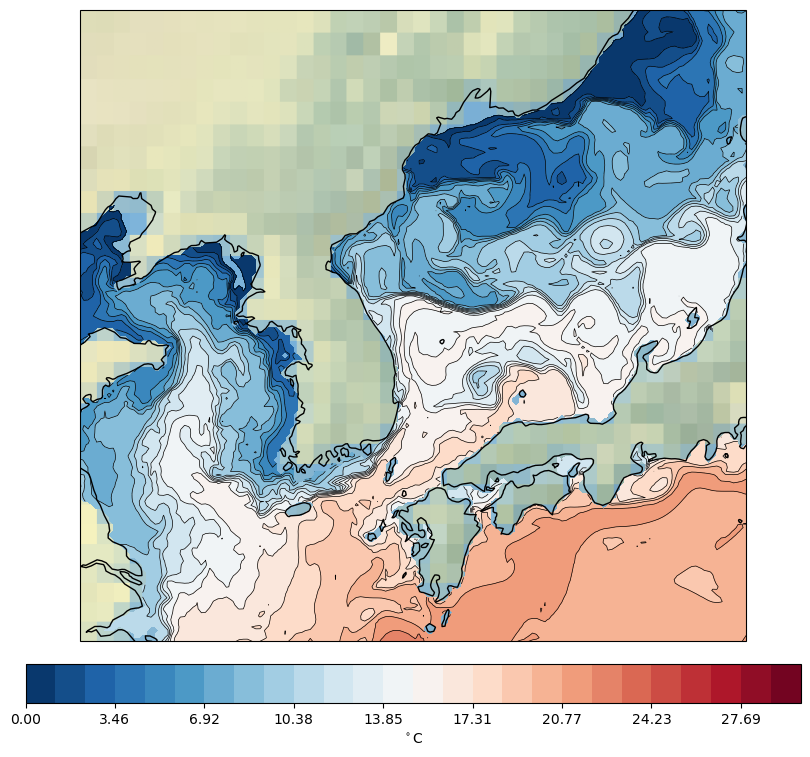

In [50]:
sstep = 1
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='50m', color='k')
# ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
img = ax.contourf(lon_geo, lat_geo, masked_data, 
           levels = np.linspace(0,30,27),
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())
ax.contour(lon_geo, lat_geo, masked_data, 
           levels = np.linspace(0,30,27),
           transform=ccrs.PlateCarree(), zorder=10, colors='k', linewidths=0.5)
ax.stock_img()
cbar = plt.colorbar(img, orientation='horizontal', pad=0.03)
cbar.set_label('$^\circ$C')

In [51]:
data3D = cat_data['3D_daily_avg'].to_dask()

In [52]:
data3D

<xarray.Dataset> Size: 339TB
Dimensions:     (time: 23741, lev: 69, ncells: 7402886, ncells_2: 14741520,
                 lev_2: 70, bnds: 2)
Coordinates:
  * time        (time) datetime64[ns] 190kB 1950-01-01 1950-01-02 ... 2014-12-31
  * lev         (lev) float64 552B 2.5 7.5 12.5 ... 5.825e+03 6.175e+03
  * lev_2       (lev_2) int32 280B 0 5 10 15 20 25 ... 5150 5400 5650 6000 6350
Dimensions without coordinates: ncells, ncells_2, bnds
Data variables:
    avg_so      (time, lev, ncells) float32 49TB dask.array<chunksize=(2, 2, 7402886), meta=np.ndarray>
    avg_thetao  (time, lev, ncells) float32 49TB dask.array<chunksize=(2, 2, 7402886), meta=np.ndarray>
    avg_uoe     (time, lev, ncells_2) float32 97TB dask.array<chunksize=(1, 1, 14741520), meta=np.ndarray>
    avg_von     (time, lev, ncells_2) float32 97TB dask.array<chunksize=(1, 1, 14741520), meta=np.ndarray>
    avg_wo      (time, lev_2, ncells) float32 49TB dask.array<chunksize=(2, 2, 7402886), meta=np.ndarray>
    lev_bnds    (time, lev, bnds) float64 26MB dask.array<chunksize=(23741, 69, 2), meta=np.ndarray>
Attributes: (12/35)
    CDI:                   Climate Data Interface version 2.4.0 (https://mpim...
    Conventions:           CF-1.7 CMIP-6.2
    number_of_grid_used:   9
    NCO:                   netCDF Operators version 5.0.6 (Homepage = http://...
    CDO:                   Climate Data Operators version 2.4.0 (https://mpim...
    activity_id:           HighResMIP
    ...                    ...
    parent_activity_id:    HighResMIP
    sub_experiment_id:     none
    experiment:            coupled historical 1950-2014
    source:                IFS-FESOM2-SR (2023): \naerosol: none, prescribed ...
    institution:           Alfred Wegener Institute, Helmholtz Centre for Pol...
    sub_experiment:        none

In [53]:
data_at_3000_m = data3D.avg_so[0,30,:].values

In [54]:
bad_interpolation = mtri.LinearTriInterpolator(triang, data_at_3000_m)(lon_geo2, lat_geo2)


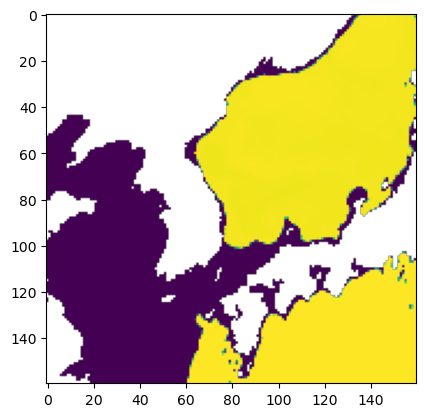

In [55]:
plt.imshow(np.flipud(bad_interpolation))


In [56]:
data_at_3000_m

array([ 0.      ,  0.      , 34.561783, ..., 34.56578 , 34.567875,
        0.      ], shape=(7402886,), dtype=float32)

In [57]:
elements.T[no_cyclic_elem]

array([[      0,       1,    1168],
       [      0,    1168,    1169],
       [      1,       3,       2],
       ...,
       [7402878, 7402880, 7402879],
       [7402882, 7402883, 7402884],
       [7402883, 7402885, 7402884]], shape=(14736628, 3), dtype=int32)

In [58]:
data_at_3000_m_on_elements = data_at_3000_m[elements.T[no_cyclic_elem]].mean(axis=1)

In [59]:
bb = data_at_3000_m_on_elements==0

In [60]:
n_true = bb.sum()          # True counts as 1
n_false = (~bb).sum()

print(n_true, n_false)

1177094 13559534


In [61]:
data_at_3000_m_on_elements[data_at_3000_m_on_elements==0] = -999


In [62]:
mmask = data_at_3000_m_on_elements==-999


In [63]:
mmask

array([False, False, False, ..., False, False, False], shape=(14736628,))

In [64]:
triang2 = mtri.Triangulation(lon, lat, elements.T[no_cyclic_elem], mask=mmask)

In [65]:
triang2.get_masked_triangles().shape


(13559534, 3)

In [66]:
triang2.triangles.shape


(14736628, 3)

In [67]:
data_at_3000_m[data_at_3000_m==0] = np.nan

In [ ]:
good_interpolation = mtri.LinearTriInterpolator(triang2, data_at_3000_m)(lon_geo2, lat_geo2)


In [ ]:
plt.imshow(np.flipud(good_interpolation))

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='50m', color='k')
# ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
img = ax.pcolormesh(lon_geo, lat_geo, good_interpolation, 
#            levels = np.linspace(2,5,27),
                    vmin=33.5, vmax=34.5,
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())
# ax.stock_img()
cbar = plt.colorbar(img, orientation='horizontal', pad=0.03)
cbar.set_label('$^\circ$C')

In [7]:
from dask.distributed import Client
import dask
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
dask.config.set({'temporary_directory': '/scratch/a/a270088/dask/'})
# client = Client(n_workers=5, threads_per_worker=1, memory_limit='50GB')
client = Client(n_workers=5, threads_per_worker=1, memory_limit='20GB')
client

<Client: 'tcp://127.0.0.1:34027' processes=5 threads=5, memory=93.13 GiB>

In [8]:
%%time
temp_std = ds['avg_tos'].sel(time=slice('1950','1951')).std(dim='time').compute()


CPU times: user 6.97 s, sys: 716 ms, total: 7.68 s
Wall time: 1min 41s
